# Test rotation MNIST

In this notebook, we solve the regression problem of estimating the angle of rotation of a rotating MNIST image.

The dataset of interest is the rotated MNIST dataset. To create this dataset, we first filter all images that belong to the digit `2`. For each of the filtered images, we assign a uniformly-distributed angle of rotation from $0$ to $\pi$. Finally, we sort the training dataset in increasing order of rotation.

**Q**: How well does an MLP perform on a test set of uniformly-distributed angles of rotation for unseen images?

In [1]:
import os
import jax
import optax
import dynamax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn

import seaborn as sns
import matplotlib.pyplot as plt
from dynamax.utils import datasets
from itertools import product
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable, Tuple
from jaxtyping import Array, Float, Int
from flax.training.train_state import TrainState

In [2]:
from rebayes import batch_sgd as bsgd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config InlineBackend.figure_format = "retina"

## Creating training dataset

In [5]:
np.random.seed(314)
num_train = 1000

train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X = jnp.array(X_train)[:num_train]
y = jnp.array(y_train)[:num_train]

ix_sort = jnp.argsort(y)
X = X[ix_sort]
y = y[ix_sort]

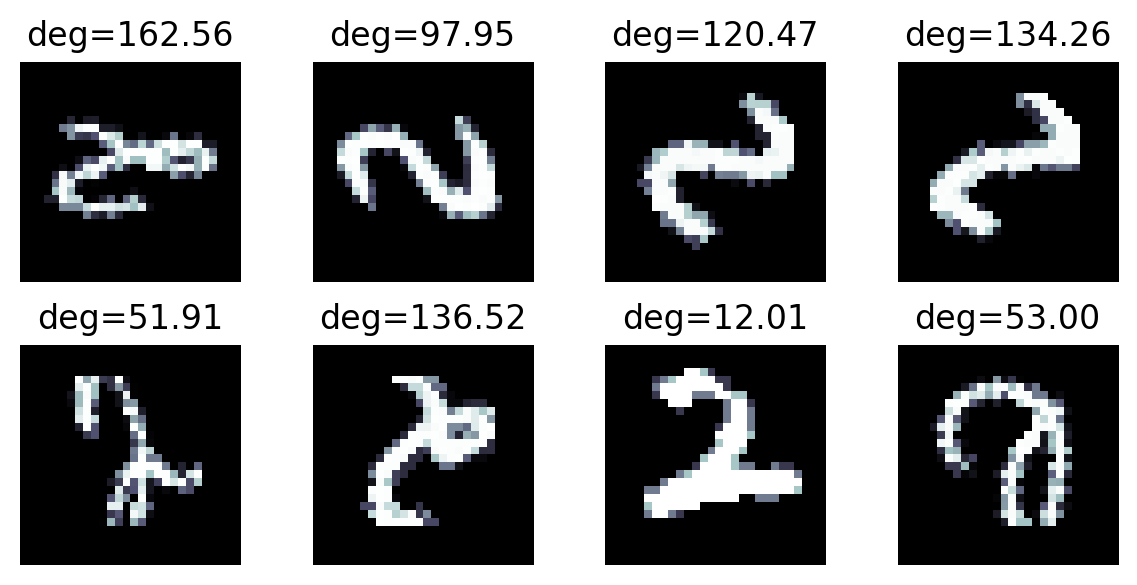

In [6]:
np.random.seed(314)
n_test = 8
ixs_test = np.random.randint(0, len(X_train), size=n_test)

fig, axs = plt.subplots(2, 4, figsize=(6, 3))
axs = axs.ravel()
for ax, ix in zip(axs, ixs_test):
    img = X_train[ix]
    deg = y_train[ix]
    ax.imshow(img.reshape(28, 28), cmap="bone")
    ax.axis("off")
    ax.set_title(f"{deg=:0.2f}")
plt.tight_layout()

# Training

## Setup

In [7]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [8]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

## Vanilla SGD

In [9]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn(params, X, y, applyfn):
    yhat = applyfn(params, X)
    nll = (y - yhat.ravel()) ** 2
    return nll.mean()


@partial(jax.jit, static_argnames=("applyfn",))
def rmae(params, X, y, applyfn):
    yhat = applyfn(params, X)
    err = jnp.abs(y - yhat.ravel())
    return err.mean()

In [131]:
%%time

num_epochs = 10_000
batch_size = 100

model = MLP(1, activation=nn.elu)
batch_init = jnp.ones((10, 28 ** 2))
params_init = model.init(key_init, batch_init)

state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-5)
)


state, losses = bsgd.train_full(
    key_init, num_epochs, batch_size, state, X, y, lossfn,
    X_test, y_test
)

CPU times: user 12.4 s, sys: 430 ms, total: 12.8 s
Wall time: 8.63 s


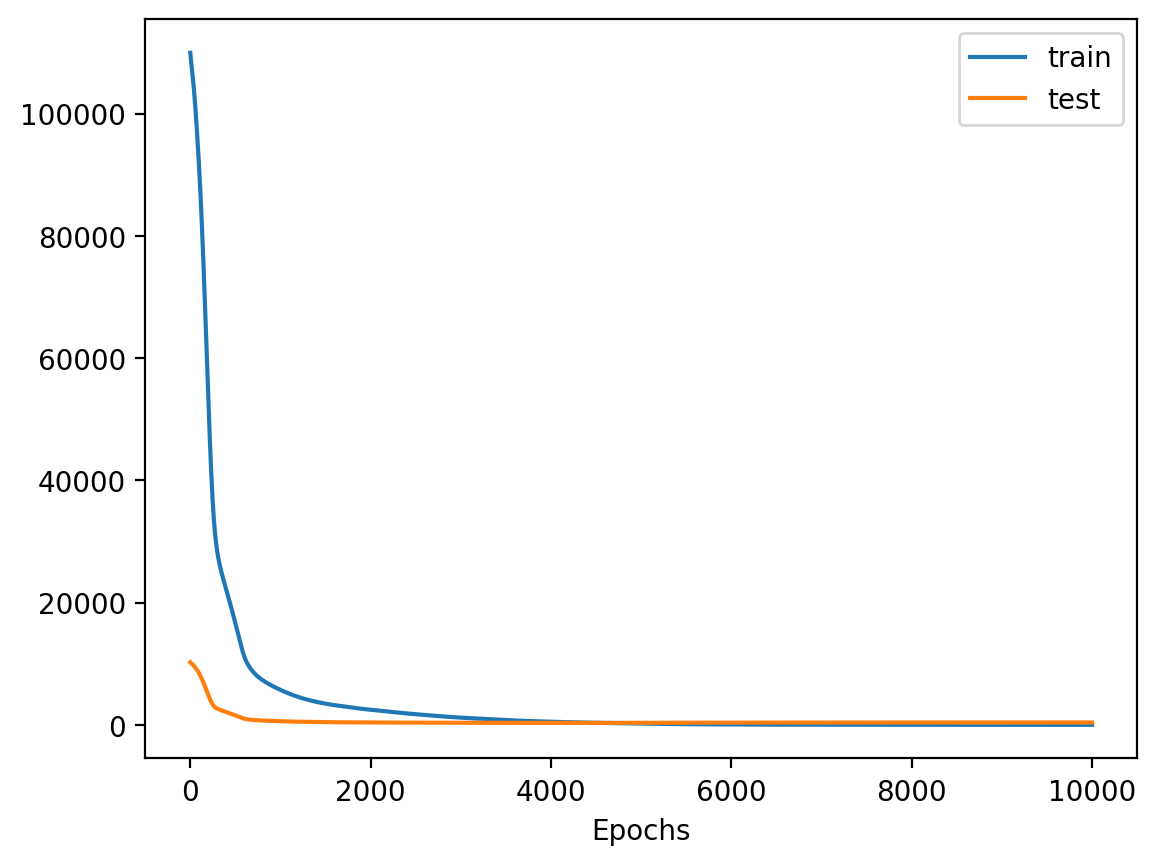

In [132]:
plt.plot(losses["train"], label="train")
plt.plot(losses["test"], label="test")
plt.legend()
plt.xlabel("Epochs");

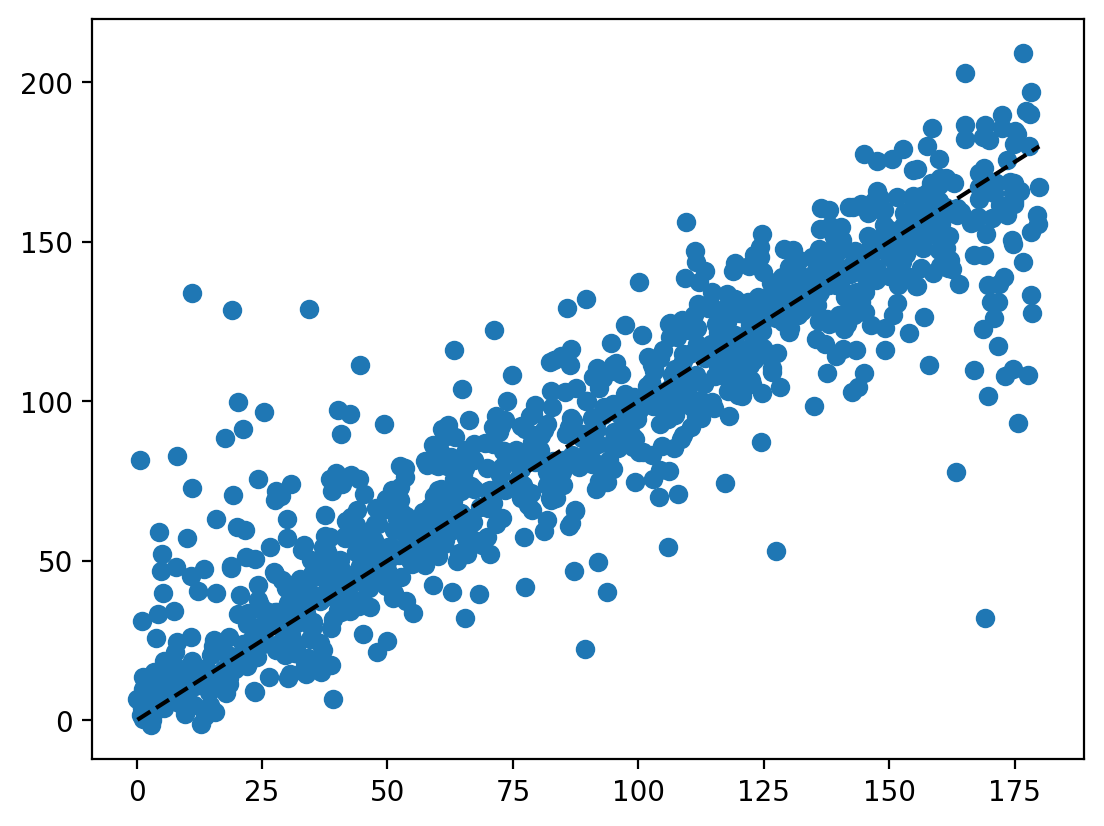

In [133]:
vmin, vmax = y_test.min(), y_test.max()
yhat_test = state.apply_fn(state.params, X_test).ravel()

plt.scatter(y_test, yhat_test)
plt.plot([vmin, vmax], [vmin, vmax], c="black", linestyle="--")

In [134]:
sgd_loss = rmae(state.params, X_test, y_test, state.apply_fn).item()
sgd_loss

13.256568908691406

# Replay buffer FIFO

Consider a buffer with size 4, the minibatches are given by
```
[x0,]
[x0, x1]
[x0, x1, x2]
[x0, x1, x2, x3]
[x1, x2, x3, x4]
[x2, x3, x4, x5]
[x3, x4, x5, x6]
...
```

In [135]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_fifo(params, X, y, ixs, applyfn):
    X_batch, y_batch = X[ixs], y[ixs]
    counter = (ixs >= 0)
    
    yhat = applyfn(params, X_batch).ravel()
    loss = (y_batch - yhat) ** 2
    loss = (loss * counter).sum() / counter.sum()
    return loss

In [136]:
%%time
state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-4)
)

buffer_size = 200
n_inner = 5

state, losses = bsgd.train_fifo(
    buffer_size, state, X, y, lossfn_fifo,
    X_test, y_test, rmae, n_inner=5
)

CPU times: user 9.18 s, sys: 151 ms, total: 9.33 s
Wall time: 4.46 s


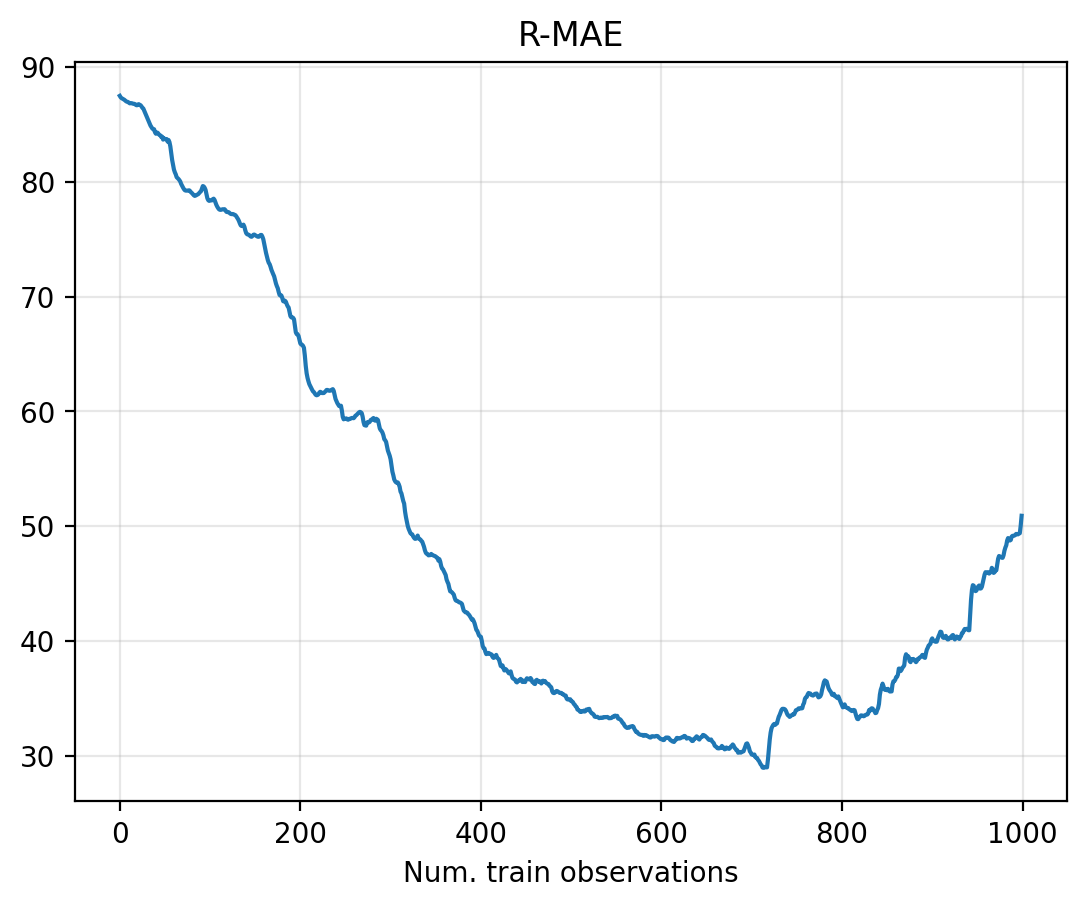

In [137]:
plt.plot(losses["test"])
plt.title("R-MAE")
plt.xlabel("Num. train observations")
plt.grid(alpha=0.3)

In [138]:
fifo_loss = rmae(state.params, X_test, y_test, state.apply_fn).item()
fifo_loss

50.894493103027344

## cartesian of hyperparams

In [61]:
n_inner_list = [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 100]
buffer_size_list = [1, 5, 10, 15, 20, 25, 50, 100]
n_buffers = len(buffer_size_list)

df_summary = []
elements = list(product(n_inner_list, buffer_size_list))
pbar = tqdm(elements)
for (n_inner, buffer_size) in pbar:
    state, losses = bsgd.train_fifo(
        buffer_size, state, X, y, lossfn_fifo,
        X_test, y_test, rmae, n_inner=n_inner
    )
    sgd_loss = rmae(state.params, X_test, y_test, state.apply_fn).item()
    entry = {
        "n_inner": n_inner,
        "buffer_size": buffer_size,
        "metric": sgd_loss
    }
    df_summary.append(entry)
df_summary = pd.DataFrame(df_summary)

  0%|          | 0/88 [00:00<?, ?it/s]

Text(0.5, 1.0, 'R-MAE — Test set')

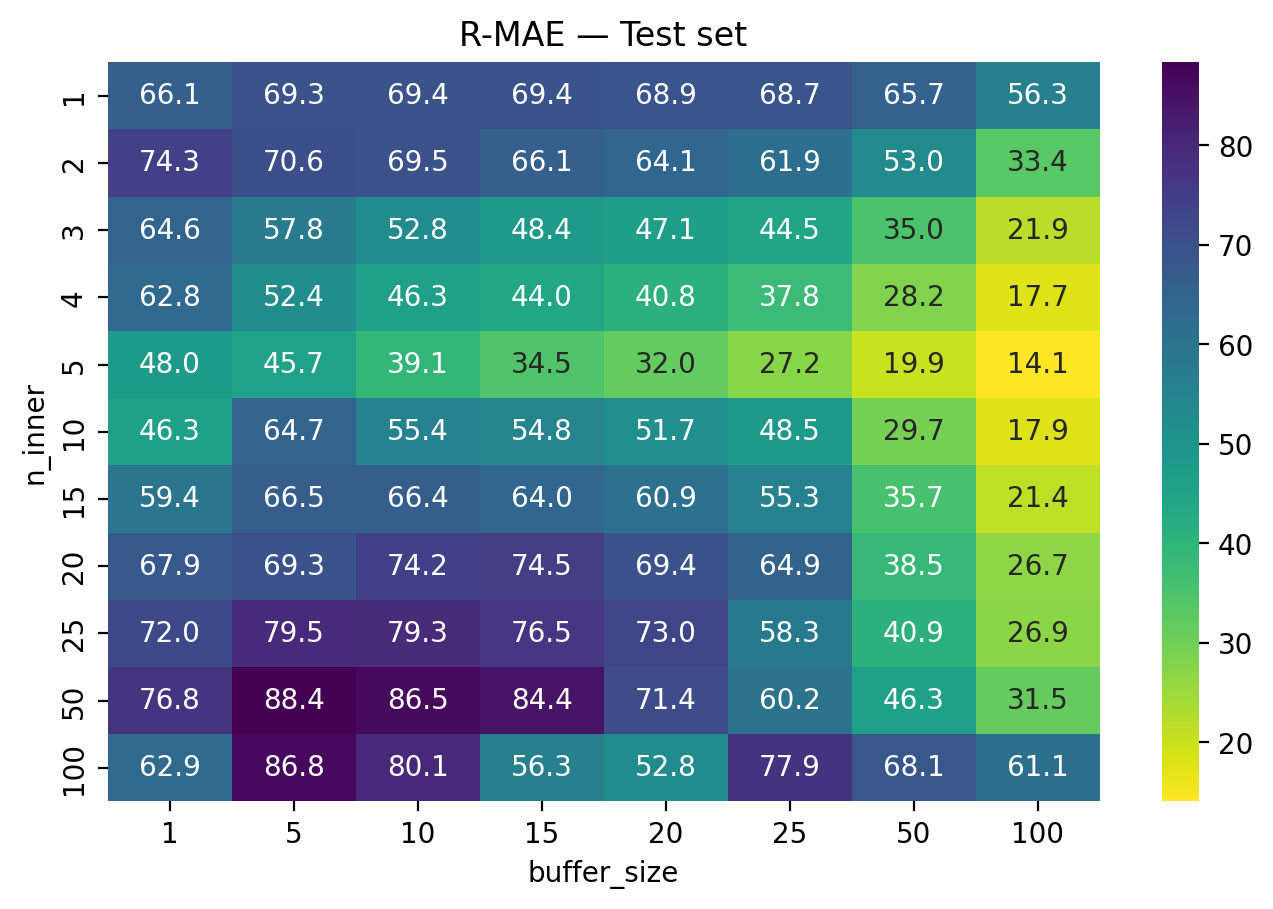

In [72]:
group = df_summary.pivot_table(index="n_inner", columns="buffer_size", values="metric")
fig, ax = plt.subplots(figsize=(8, 4.8))
sns.heatmap(group, cmap="viridis_r", annot=True, fmt="0.1f", ax=ax)
plt.title("R-MAE — Test set")

## New API

In [151]:
%%time

buffer_size = 100
n_inner = 1

state_init = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-4)
)

rebayes = bsgd.ReFifoSGD(buffer_size, lossfn_fifo, n_inner=n_inner)
state, losses = rebayes.scan(state_init, X, y, X_test, y_test, rmae)

CPU times: user 2.95 s, sys: 58.1 ms, total: 3.01 s
Wall time: 1.64 s


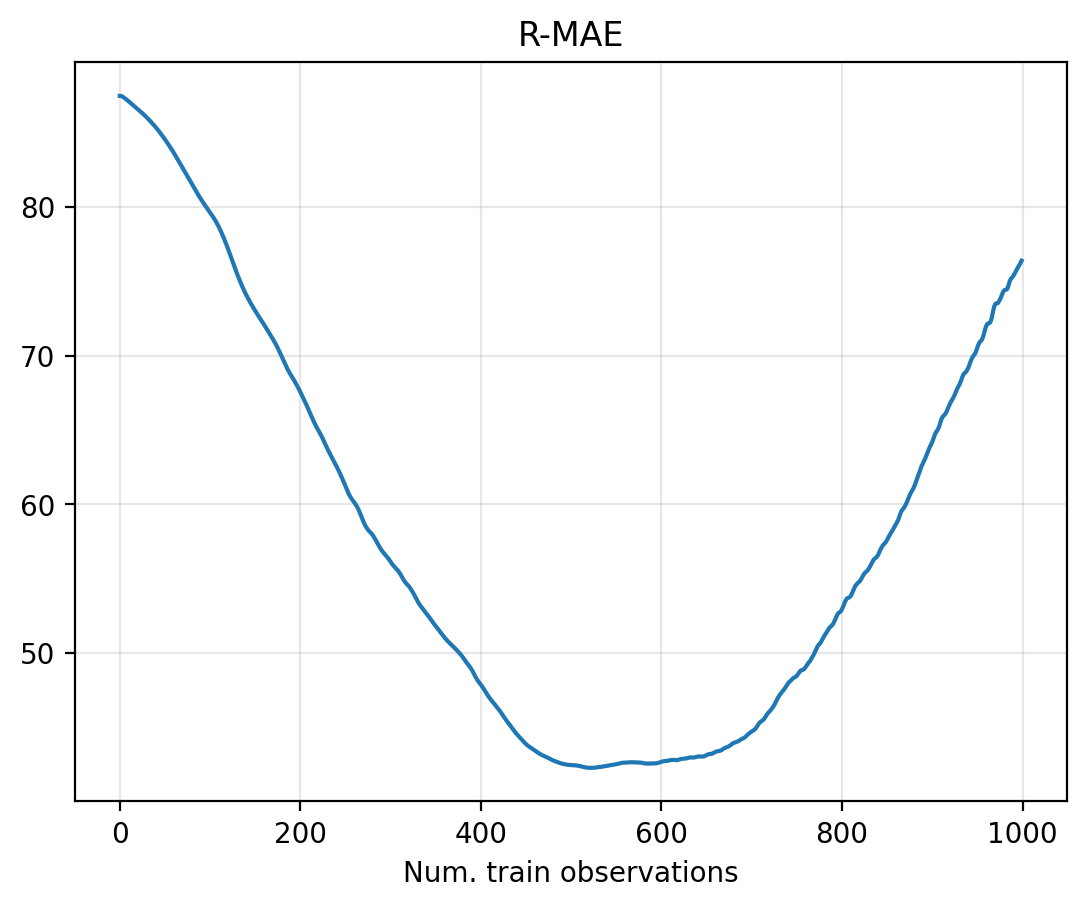

In [152]:
plt.plot(losses["test"])
plt.title("R-MAE")
plt.xlabel("Num. train observations")
plt.grid(alpha=0.3)

In [153]:
yhat_test = rebayes.predict_obs(state, X_test).ravel()
rmae_test = jnp.abs(yhat_test - y_test).mean()
rmae_test

Array(76.37913, dtype=float32)

In [154]:
buffer_size_list = [1, 5, 10, 20, 50, 100, 200, 500]
n_buffers = len(buffer_size_list)

n_inner = 2

test_losses = {}
for buffer_size in tqdm(buffer_size_list):
    rebayes = bsgd.ReFifoSGD(buffer_size, lossfn_fifo, n_inner=n_inner)
    state, losses = rebayes.scan(state_init, X, y, X_test, y_test, rmae)
    test_losses[buffer_size] = losses["test"]

  0%|          | 0/8 [00:00<?, ?it/s]

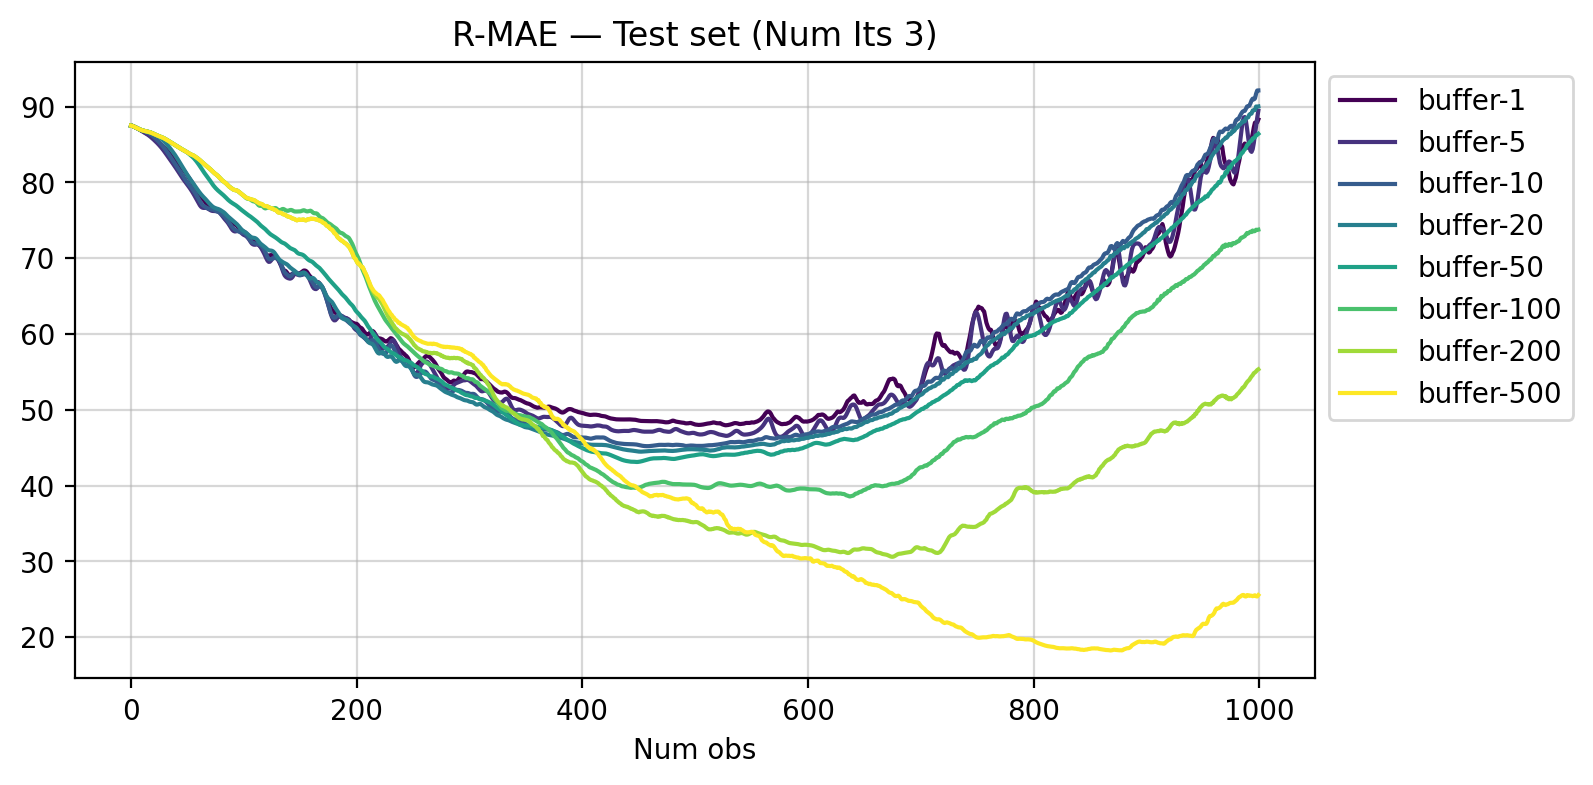

In [155]:
fig, ax = plt.subplots(figsize=(8, 4))
n_inner = 3
colors = plt.cm.viridis(np.linspace(0, 1, n_buffers))

for c, buffer_size in zip(colors, buffer_size_list):
    loss_test = test_losses[buffer_size]
    plt.plot(loss_test, c=c, label=f"buffer-{buffer_size}")
    
plt.xlabel("Num obs")
plt.title(f"R-MAE — Test set (Num Its {n_inner})")
# plt.axhline(y=sgd_loss, c="tab:gray", linestyle="--", label="SGD minibatch")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.5)

## Style of buffer

In this section, we train an MLP with a replay buffer of size 10 based on a train dataset $\mathcal{D}_\text{train}$ and test dataset $\mathcal{D}_\text{test}$. We shuffle $\mathcal{D}_\text{train}$ in three different ways:
1. We arrange the features $\bf X$ based on the angle of rotation: from lowest to highest ($0\to\pi$)
2. We arrange the features $\bf X$ based on the angle of rotation from highest to lowest ($\pi\to 0$)
3. We do not arrange the features $\bf X$.

In [21]:
np.random.seed(3141)
num_train = 100

train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

n_train = len(X_train)
choice_ix = np.random.choice(n_train, size=n_train)
X = jnp.array(X_train)[choice_ix]
y = jnp.array(y_train)[choice_ix]

ix_sort = jnp.argsort(y)
# Do not modify
X0 = X[:]
y0 = y[:]

# Lowest to highest
X1 = X[ix_sort]
y1 = y[ix_sort]

# Highest to lowest
X2 = X[ix_sort[::-1]]
y2 = y[ix_sort[::-1]]

In [22]:
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)
ix_sort = jnp.argsort(y_train)

X0 = jnp.array(X_train)[:num_train]
y0 = jnp.array(y_train)[:num_train]

# Lowest to highest
X1 = X0[ix_sort]
y1 = y0[ix_sort]

# Highest to lowest
X2 = X0[ix_sort[::-1]]
y2 = y0[ix_sort[::-1]]

In [23]:
n_inner = 3
buffer_size = 10

dataset_configs = {
    "iid": (X0, y0),
    "increasing": (X1, y1),
    "decreasing": (X2, y2)
}

In [24]:
res = []
num_runs = 15
keys_init = jax.random.split(key_init, num_runs)

for keyinit in tqdm(keys_init):
    params_init = model.init(keyinit, batch_init)

    state_init = TrainState.create(
        apply_fn=model.apply,
        params=params_init,
        tx=optax.adam(1e-4)
    )
    
    for config, (X, y) in dataset_configs.items():
        state, losses = train_xval_fifo(
            state_init, X, y, X_test, y_test, loss_grad, rmae,
            buffer_size=buffer_size, n_inner=n_inner,
            leave=False
        )
        train_losses, test_losses = losses

        entries = [{
            "n_obs": n_obs + 1,
            "config": config,
            "loss": loss.item()
        } for n_obs, loss in enumerate(test_losses)]

        res.extend(entries)
res = pd.DataFrame(res)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'R-MAE — test set')

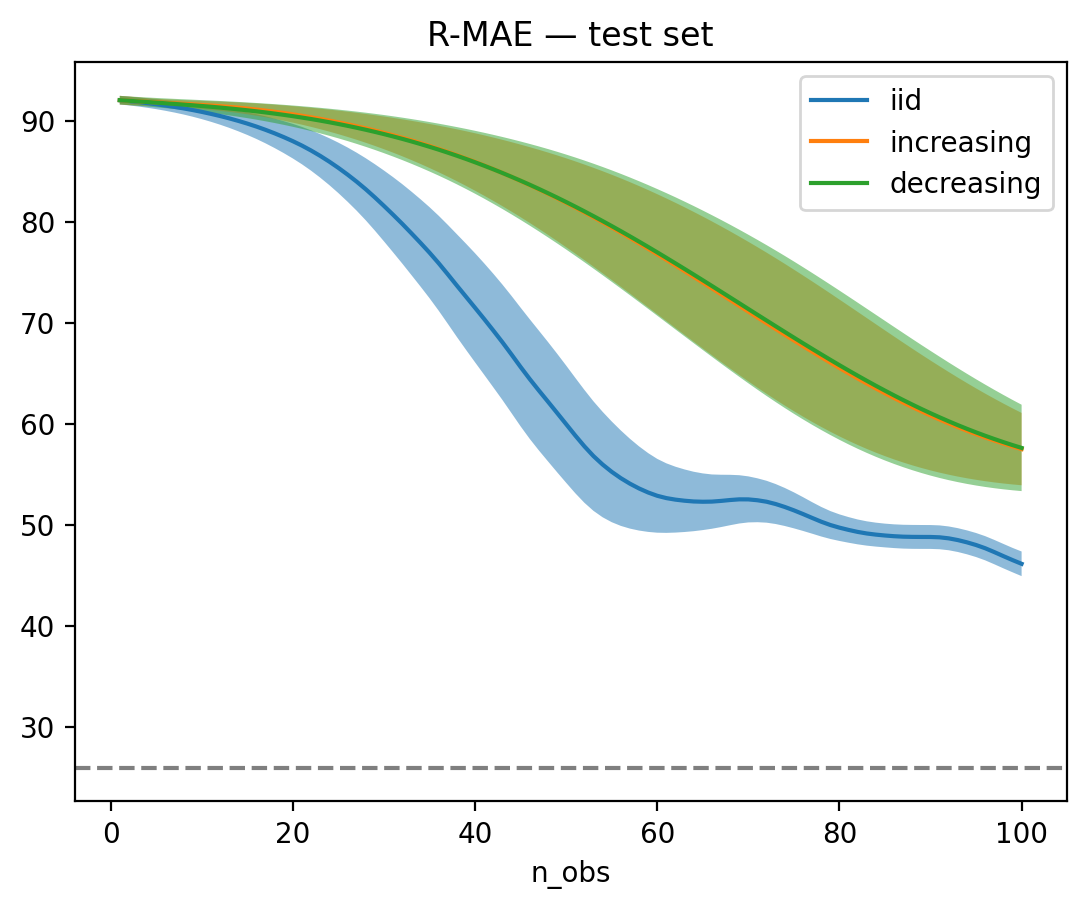

In [25]:
configs = res.config.unique()
aggres = res.pivot_table(index="n_obs", columns="config", values="loss", aggfunc=["mean", "std"])
for col in configs:
    xvals = aggres["mean"].index
    lbound = aggres["mean"][col] - 2 * aggres["std"][col]
    ubound = aggres["mean"][col] + 2 * aggres["std"][col]
    aggres["mean"][col].plot(label=col)
    plt.fill_between(xvals, lbound, ubound, alpha=0.5)
plt.legend()
plt.axhline(y=sgd_loss, c="tab:gray", linestyle="--", label="SGD minibatch")
plt.title("R-MAE — test set")